In [ ]:
import warnings;
warnings.simplefilter('ignore')

In [ ]:
# !pip install pystan
# !pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]


df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object
df['date'] += pd.DateOffset(years=7)

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2024-04-30'].reset_index(drop=False)
test_df = temp_df.loc['2024-05-01':].reset_index(drop=False)

train_df.head()


,date,store,item,sales,year,month,day,weekday
0,2020-01-01,1,1,13,2020,1,1,2
1,2020-01-02,1,1,11,2020,1,2,3
2,2020-01-03,1,1,14,2020,1,3,4
3,2020-01-04,1,1,13,2020,1,4,5
4,2020-01-05,1,1,10,2020,1,5,6


In [ ]:
train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2020-01-01,1,1,13,2020,1,1,2
1,2020-01-02,1,1,11,2020,1,2,3
2,2020-01-03,1,1,14,2020,1,3,4
3,2020-01-04,1,1,13,2020,1,4,5
4,2020-01-05,1,1,10,2020,1,5,6


In [ ]:
test_df.tail()

,date,store,item,sales,year,month,day,weekday
240,2024-12-27,1,1,14,2024,12,27,4
241,2024-12-28,1,1,19,2024,12,28,5
242,2024-12-29,1,1,15,2024,12,29,6
243,2024-12-30,1,1,27,2024,12,30,7
244,2024-12-31,1,1,23,2024,12,31,1


In [ ]:
new_df = train_df[['date', 'sales']]
new_df.columns = ['ds', 'y']
new_df.head()

,ds,y
0,2020-01-01,13
1,2020-01-02,11
2,2020-01-03,14
3,2020-01-04,13
4,2020-01-05,10


In [ ]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(new_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jekd0m_/e97gl0z0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9jekd0m_/z49c39_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75516', 'data', 'file=/tmp/tmp9jekd0m_/e97gl0z0.json', 'init=/tmp/tmp9jekd0m_/z49c39_p.json', 'output', 'file=/tmp/tmp9jekd0m_/prophet_modelcq2orjbz/prophet_model-20250106132139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=244,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,13.551149,-1.661234,16.226358,13.551149,13.551149,-6.601342,-6.601342,-6.601342,2.2344,...,-3.645397,-3.645397,-3.645397,-5.190346,-5.190346,-5.190346,0.0,0.0,0.0,6.949807
1,2020-01-02,13.556578,-0.442364,17.945691,13.556578,13.556578,-4.494160,-4.494160,-4.494160,2.2344,...,-1.550604,-1.550604,-1.550604,-5.177957,-5.177957,-5.177957,0.0,0.0,0.0,9.062418
2,2020-01-03,13.562008,1.348095,18.953453,13.562008,13.562008,-3.879110,-3.879110,-3.879110,2.2344,...,-0.930541,-0.930541,-0.930541,-5.182970,-5.182970,-5.182970,0.0,0.0,0.0,9.682897
3,2020-01-04,13.567437,1.905144,19.287152,13.567437,13.567437,-3.010397,-3.010397,-3.010397,2.2344,...,-0.040445,-0.040445,-0.040445,-5.204352,-5.204352,-5.204352,0.0,0.0,0.0,10.557040
4,2020-01-05,13.572867,2.788779,20.524651,13.572867,13.572867,-1.584642,-1.584642,-1.584642,2.2344,...,1.421525,1.421525,1.421525,-5.240568,-5.240568,-5.240568,0.0,0.0,0.0,11.988224


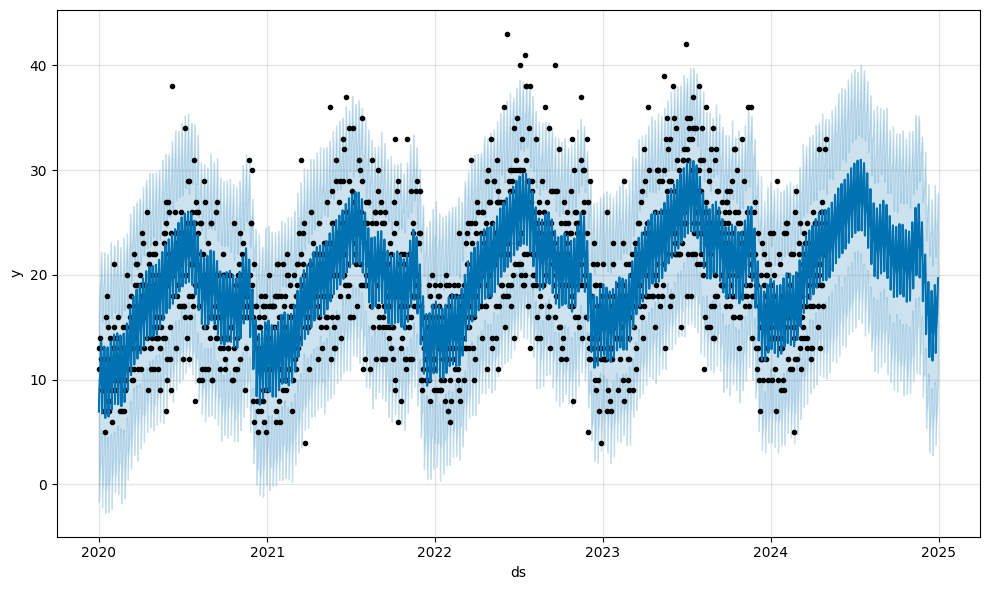

In [ ]:
plot1 = m.plot(forecast)

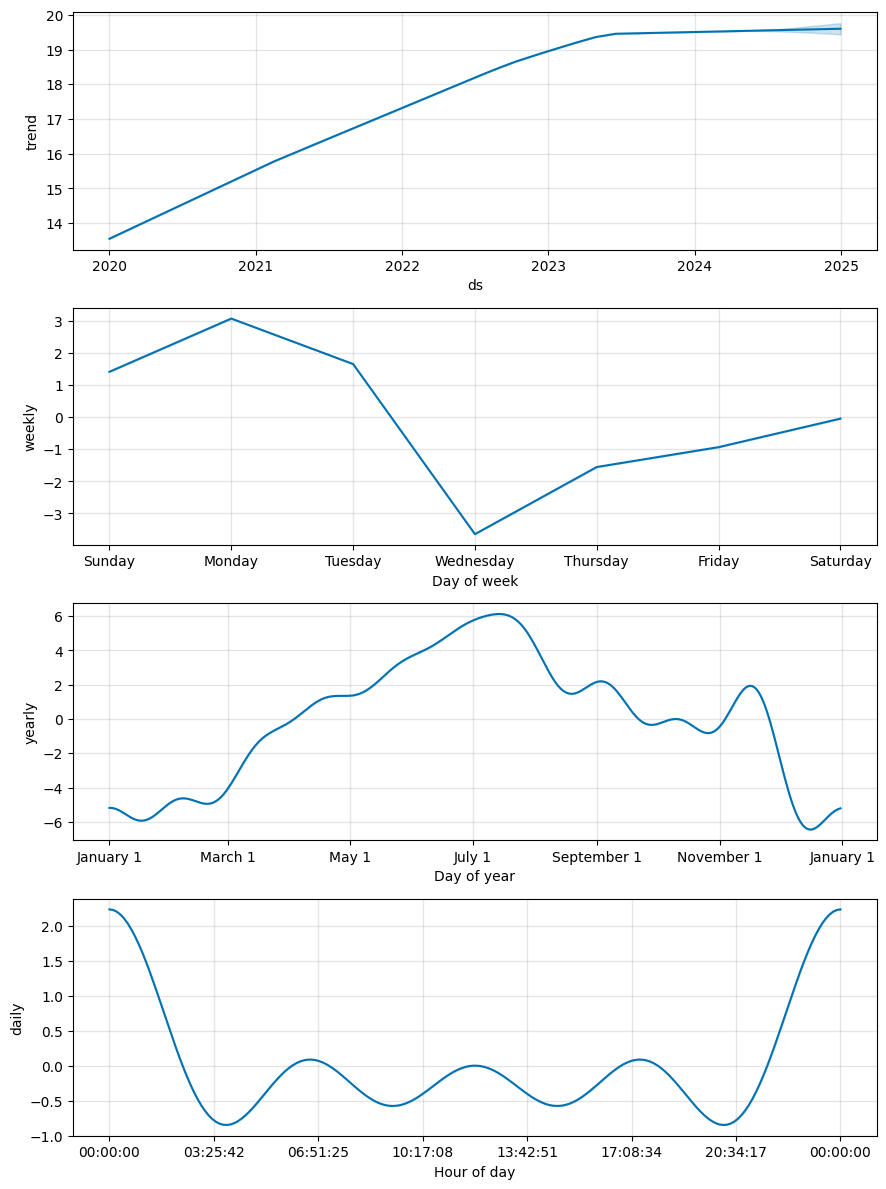

In [ ]:
plt2 = m.plot_components(forecast)